In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from figaro.mixture import DPGMM
from figaro.plot import plot_median_cr
from figaro.utils import rejection_sampler, get_priors
from figaro.cosmology import CosmologicalParameters
from figaro.load import save_density, load_density
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba import njit
from figaro import plot_settings

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [3]:
# Mass distribution
from population_models.mass import plpeak

# dL distributions
# @njit
def dLsq(DL, DLmax = 5000):
    return 3*DL**2/DLmax**3

In [5]:
true_H0 = 70. # km/s/Mpc

n_draws_samples = 4000
n_draws_figaro = 1000
Mz_max = 100

# Generate samples from source distribution
valid = False
while not valid:
    dL_sample = rejection_sampler(n_draws_samples, dLsq, [0,5000])
    M_sample  = rejection_sampler(n_draws_samples, plpeak, [0,200])
    z_sample  = np.array([CosmologicalParameters(true_H0/100., 0.315, 0.685, -1., 0., 0.).Redshift(d) for d in dL_sample])
    Mz_sample = M_sample * (1 + z_sample)
    valid = Mz_sample.min() > 0
# data_realistic = Mz_sample[np.random.uniform(0,1,len(Mz_sample)) < Mz_sample/Mz_max] # Selection effect
data_realistic = Mz_sample

/Users/thomas.ng/Documents/GitHub/pop_models_lvk/population_models/mass.py:29: RuntimeWarning: divide by zero encountered in power
  p = m**-alpha * (alpha-1.)/(mmin**(1.-alpha)-mmax**(1.-alpha))
/Users/thomas.ng/Documents/GitHub/pop_models_lvk/population_models/mass.py:10: RuntimeWarning: overflow encountered in exp
  p[idx]       = 1./(1.+np.exp(exponent))


In [8]:
np.savetxt('test/samples.txt', data_realistic)

In [7]:
# mix_realistic = DPGMM([[data_realistic.min(), data_realistic.max()]], prior_pars=get_priors([[data_realistic.min(), data_realistic.max()]], data_realistic, probit = False), probit = False)
# draws_realistic = np.array([mix_realistic.density_from_samples(data_realistic) for _ in tqdm(range(n_draws_figaro))])

# Use FIGARO pipeline instead

In [11]:
data_realistic = np.loadtxt('test/samples.txt')
draws_realistic = load_density("test/draws_samples.json")

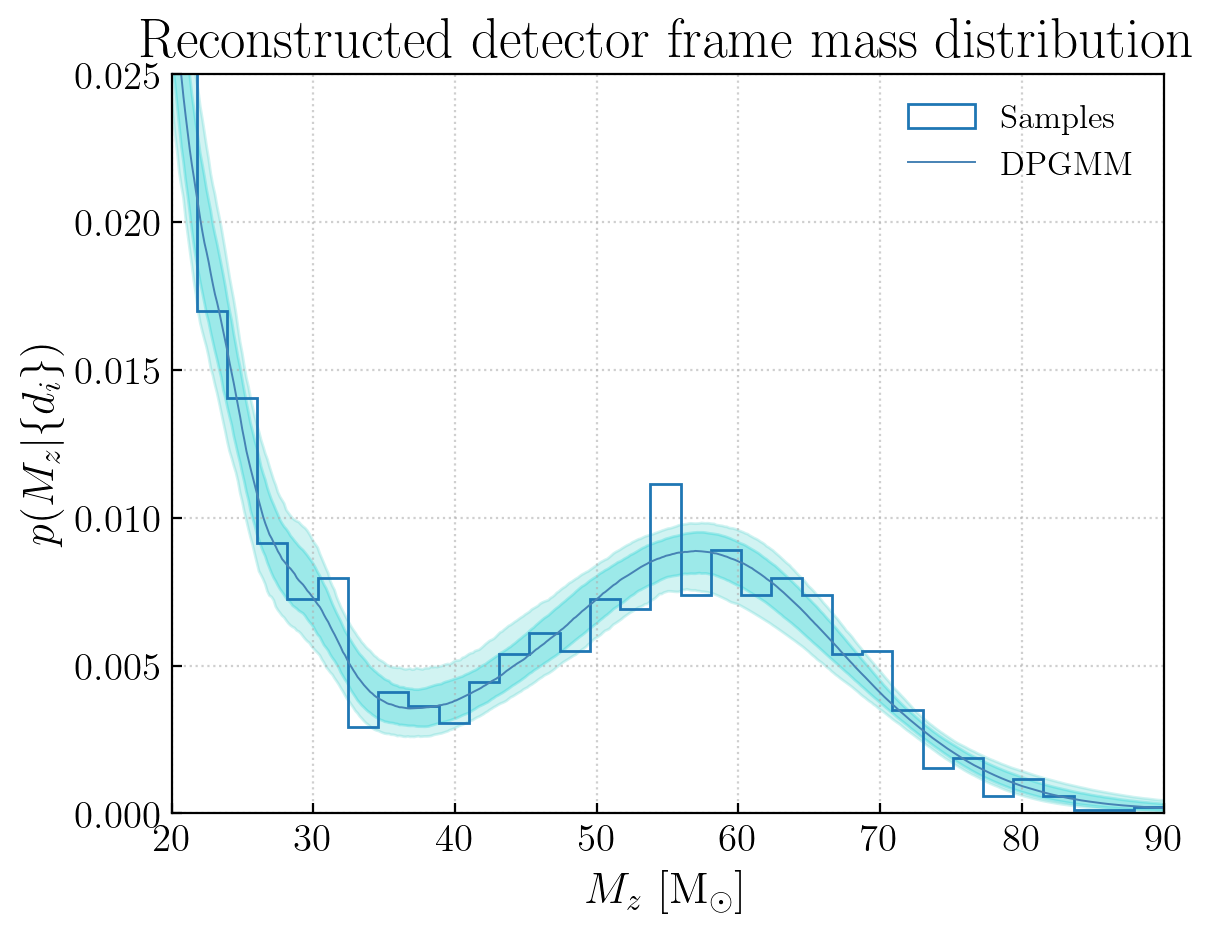

In [12]:
fig = plot_median_cr(draws_realistic, samples=data_realistic, save=True, show=False)
fig.axes[0].set_xlabel('$M_z\ [\mathrm{M}_\odot]$')
fig.axes[0].set_ylabel('$p(M_z|\{d_i\})$')
fig.axes[0].set_xlim(20,90)
fig.axes[0].set_ylim(0,0.025)
fig.axes[0].set_title('$\mathrm{Reconstructed\ detector\ frame\ mass\ distribution}$', fontsize=20)
fig.savefig('./observed_figaro.pdf', bbox_inches='tight')
fig

/var/folders/d3/01xbdqfn0wg_yv1z2hkz_6_r0000gn/T/ipykernel_24876/1301286502.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


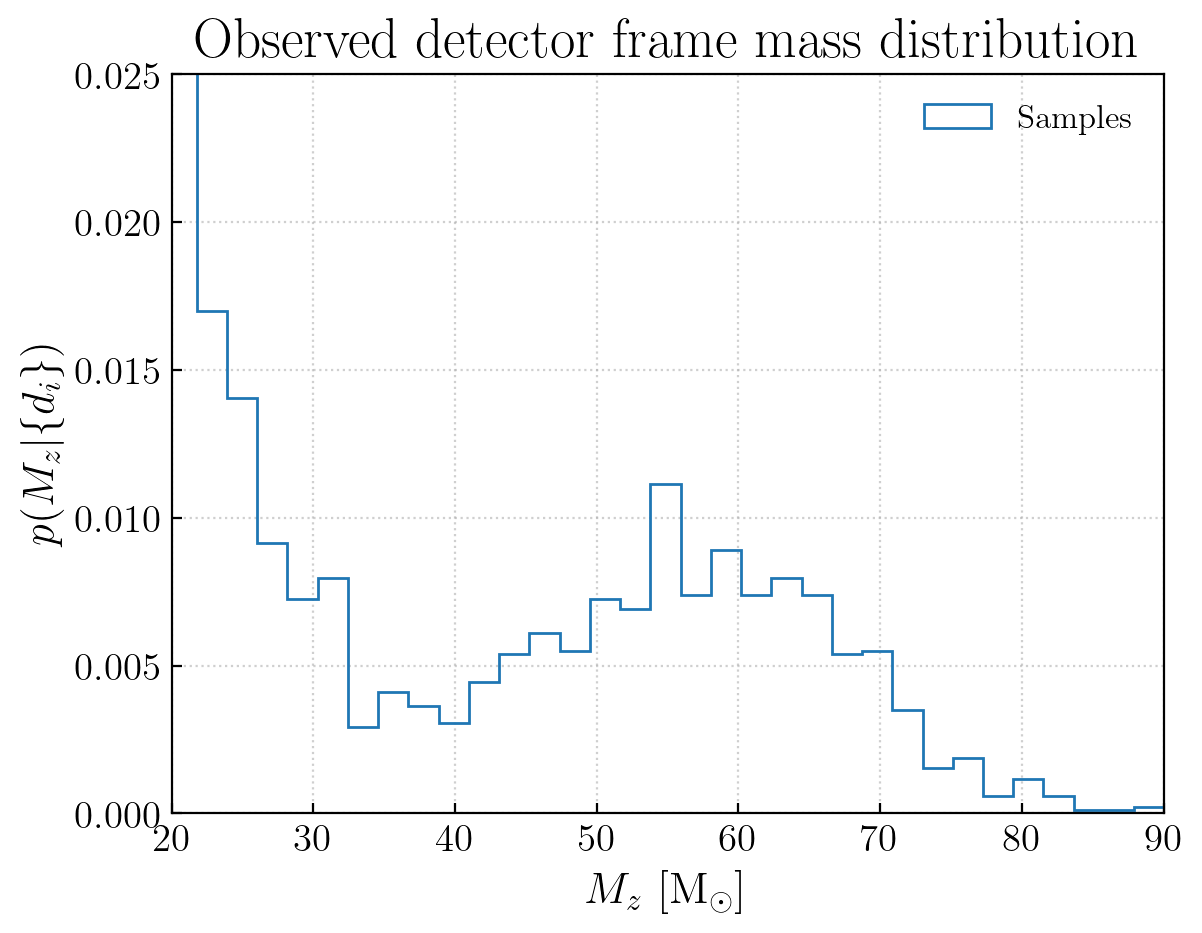

In [13]:
fig, ax = plt.subplots()
ax.hist(data_realistic, bins = int(np.sqrt(len(data_realistic))), histtype = 'step', density = True, label = '$\mathrm{Samples}$')
ax.set_xlabel('$M_z\ [\mathrm{M}_\odot]$')
ax.set_ylabel('$p(M_z|\{d_i\})$')
ax.set_xlim(20,90)
ax.set_ylim(0,0.025)
fig.axes[0].set_title('$\mathrm{Observed\ detector\ frame\ mass\ distribution}$', fontsize=20)
ax.legend()
fig.savefig('./observed_mass.pdf', bbox_inches='tight')
fig.show()